# Machine Learning Dynamical Systems

In [ ]:
### Install dependencies 
!pip install numpy matplotlib scipy
!pip install tqdm plotly
!pip install torch torchvision torchaudio
!pip install optuna
!pip install pytorch-lightning
!pip install google
!pip install odeintw

In [12]:
#!/usr/bin/env python3
%matplotlib inline

# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from odeintw import odeintw
from sklearn.metrics import r2_score

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Trainig with lighninig
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
from pytorch_lightning import Callback


# Import models
from models import LSTM,FFNet, ESN, Transformer
from auto_encoders import ConvAE, ConvVAE, VarFFAE
#from Informer.model import InformerStack
#from pyESN import ESN


# Import plot functions
from plot import gen_trajectory, plot_trajectory, compare_trajectories, plot_3Dtrajectory, poincare_plot, plot_powspec

# Import dataset
from dataset import DynSysDataset

# Import callbacks
from callbacks import MetricsCallback

# Import functions 
from utils import Lorenz63, Roessler, Lorenz96, EuDLoss, RK4Loss, CeDLoss, Sampler, nKLDivLoss, R2Score, ENLoss

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
import plotly
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

## Prepare data

### Parameters and systems

In [13]:
### Parameters
dt = 0.01
train_steps = 10000
val_steps = 2000
test_steps = 10000
seq_len = 1000
feedforward_steps = 2
discard = 1000
include_time = False
convolution = False

### Systems
## Lorenz63
l63 = Lorenz63(rho=28.0, sigma=10.0, beta=8.0/3.0)
## Lorenz96
n_dim = 20
np.random.seed(0)
true_args = torch.tensor((np.random.uniform(0.9, 1.1, n_dim), np.random.uniform(7.9, 8.1, n_dim)),
                         dtype=torch.float32, requires_grad=False)
l96 = Lorenz96(true_args)

## Rössler
roess = Roessler(a=0.37, b=0.2, c=5.7)




### Dataset and Dataloader

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


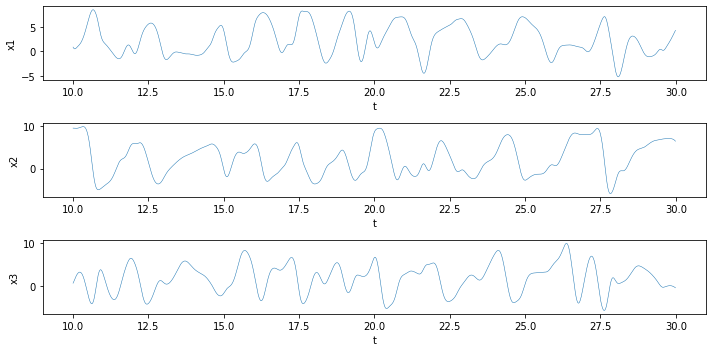

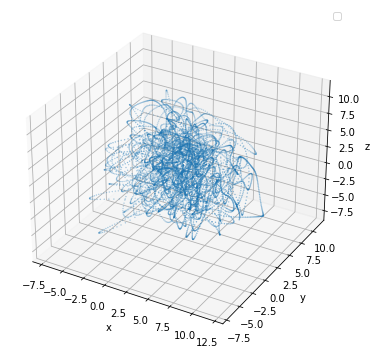

In [14]:
# Define system to use
true_system = l96
true_system.args.requires_grad = False

# Train dataset
state0 = [1.0]*true_system.dim
train_states = DynSysDataset(state0, true_system, dt, train_steps, seq_len, discard, include_time=include_time, convolution=convolution)
t_train = train_states.time
train_dataset = train_states.dataset

# Validtion dataset
state0 = [1.1]*true_system.dim
val_states =  DynSysDataset(state0, true_system, dt, val_steps, seq_len, discard, include_time=include_time, convolution=convolution)
t_val = val_states.time
val_dataset = val_states.dataset

# Test dataset
state0 = train_dataset[-1][:n_dim]
test_states =  DynSysDataset(state0, true_system, dt, test_steps, seq_len, discard, include_time=include_time, convolution=convolution)
t_test = test_states.time
test_dataset = test_states.dataset

### Dataloader
batch_size = 20
train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_states, batch_size=batch_size,num_workers=0, shuffle=True)

### Plot dataset
# Train dataset
train_dynamics = plot_trajectory(train_dataset, time=t_train, n_var=3, labels=["x","y","z"], prediction_steps=2000)
train_attractor = plot_3Dtrajectory(train_dataset, var=[1,3,6])


## Recurrent Neural Networks

### LSTM

### Hyperparameter optimization

In [ ]:
### Hyperparameter optmization
#Check if the GPU is available


# Define annealing
max_num_epochs = 2000
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
    
# Define loss function
loss_fn = PILoss(dt,field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0), annealing= [1]*max_num_epochs)

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True)
    hidden_units = trial.suggest_int("hidden_units", 10,200)
    layers_num = trial.suggest_int("layers_num", 2,5)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
   
    # Define network
    input_size = 3
    model = LSTM(input_size, hidden_units, layers_num, drop_p)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
        
    # Train
    max_num_epochs = 100
    early_stopping = False
    train_loss, val_loss = pi_train(model, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
    
    # Metric to be minimized is the last validation loss
    return np.mean(val_loss[-5:])


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials= 20)
study.best_params  

### Learning the dynamics

torch.Size([10, 1000, 20])
Network initialized
Parameter containing:
tensor([[1.0098, 1.0430, 1.0206, 1.0090, 0.9847, 1.0292, 0.9875, 1.0784, 1.0927,
         0.9767, 1.0583, 1.0058, 1.0136, 1.0851, 0.9142, 0.9174, 0.9040, 1.0665,
         1.0556, 1.0740],
        [8.0957, 8.0598, 7.9923, 8.0561, 7.9237, 8.0280, 7.9287, 8.0889, 8.0044,
         7.9829, 7.9529, 8.0548, 7.9912, 8.0137, 7.9038, 8.0235, 8.0224, 8.0234,
         8.0887, 8.0364]])
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
         8., 8.]], requires_grad=True)


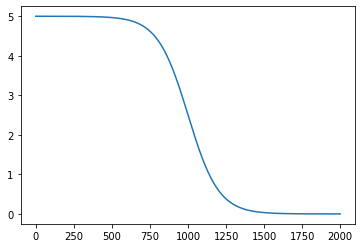

In [26]:
### Initialization
max_num_epochs = 2000
## Annealing
# Exponential
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
# Inverse sigmoid
c = 0.01
d = 0.5
sig_cv = [initial_value*np.exp(-c*(i-max_num_epochs*d))/(1. + np.exp(-c*(i-max_num_epochs*d))) for i in range(max_num_epochs)]
plt.plot(sig_cv)

# Define loss function 
#pi_loss_fn = RK4Loss(dt, field = system.field) # physical informed
dd_loss_fn = nn.MSELoss()
args_loss_fn = ENLoss(dt)



# Define input size
input_size = 4 if include_time else 3

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and define network
torch.manual_seed(0)
args = torch.tensor((np.ones((n_dim,)), 8*np.ones((n_dim,))), dtype=torch.float32, requires_grad=True)

system = Lorenz96(args)
#system.args.requires_grad = False
pi_loss_fn = RK4Loss(dt, model=system)

# Check batch dimension
print(next(iter(train_dataloader)).shape)
net_pi = LSTM(input_size=system.dim, hidden_units=100, layers_num=2, drop_p=0.3, pi_loss_fn=pi_loss_fn, dd_loss_fn=None,
              hypothesis=true_system, lr=0.001, feedforward_steps=1, annealing=None)


# Print args
print(true_system.args)
print(system.args)

In [25]:
# Load from file
state_dict = torch.load("trained_models/lstm_pi_l96_2000_s1.torch")
net_pi.load_state_dict(state_dict)


FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/lstm_pi_l96_2000_s1.torch'

In [27]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_pi, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type     | Params
----------------------------------------
0 | pi_loss_fn | RK4Loss  | 40    
1 | hypothesis | Lorenz96 | 40    
2 | rnn        | LSTM     | 129 K 
3 | out        | Linear   | 2.0 K 
----------------------------------------
131 K     Trainable params
40        Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)


Training device: cpu


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [28]:
print(true_system.args)
print(system.args)

Parameter containing:
tensor([[1.0098, 1.0430, 1.0206, 1.0090, 0.9847, 1.0292, 0.9875, 1.0784, 1.0927,
         0.9767, 1.0583, 1.0058, 1.0136, 1.0851, 0.9142, 0.9174, 0.9040, 1.0665,
         1.0556, 1.0740],
        [8.0957, 8.0598, 7.9923, 8.0561, 7.9237, 8.0280, 7.9287, 8.0889, 8.0044,
         7.9829, 7.9529, 8.0548, 7.9912, 8.0137, 7.9038, 8.0235, 8.0224, 8.0234,
         8.0887, 8.0364]])
Parameter containing:
tensor([[1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050,
         1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050, 1.0050,
         1.0050, 1.0050],
        [7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950,
         7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950, 7.9950,
         7.9950, 7.9950]], requires_grad=True)


AttributeError: 'MetricsCallback' object has no attribute 'args_loss_log'

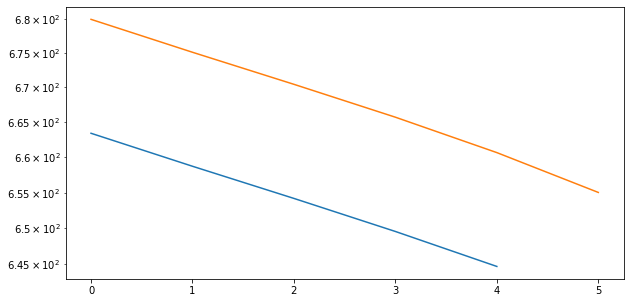

In [29]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
if args is not None:
    ax.semilogy(metrics_callback.args_loss_log, label="Args discrepacy")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("images/loss_lstm_l96_s1.png")
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
from scipy.signal import argrelextrema
net_states = gen_trajectory(net_pi.cpu(), test_dataset[0],prediction_steps=30000)
max_net_states = net_states[argrelextrema(net_states, np.greater)[0]]
max_test_dataset = test_dataset[argrelextrema(test_dataset, np.greater)[0]]
print(max_net_states.shape)

#poincare_plot(max_test_dataset, max_net_states, filename="max_poincare_plot_l63.png")


In [ ]:
### Plot trajectories

# Compare trajectory
compare = compare_trajectories(net_states, test_dataset, t_test, n_var=3, filename="images/lstm_pi_compare_l96_2000_s1.png", prediction_steps=1000)
# Attractor
plot_3Dtrajectory(net_states, filename="images/lstm_pi_predict_l96_2000_s1.png", color=None)
print(net_states[1:, 0].size, net_states[:-1,0].size)
# Poincare map
poincare_plot(net_states, test_dataset, filename="images/poincare_pi_l96_2000_s1.png", prediction_steps=1000)
# Power spectrum
plot_powspec(net_states, test_dataset, filename="images/powspec_pi_l96_2000_s1.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net_pi.state_dict(),"trained_models/lstm_pi_roess_3000_s1.torch")


### Autograd time differantiation

In [ ]:
# Train dataset
state0 = [1.0, 1.0, 1.0]
include_time = True
train_states = DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
t_train = train_states.time
train_dataset = train_states.dataset
train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)

In [ ]:
# Define network
max_num_epochs = 2000
c = 0.01
d = 0.5

loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0), include_time=include_time)

input_size = 4 if include_time else 3
params = {
    "input_size" : 4,
    "hidden_units" : 100,
    "layers_num" : 2,
    "drop_p" : 0.3,
    "loss_fn" : loss_fn,
    "lr" : 0.01,
    "feedforward_steps" : 1,
    "curriculum_learning" : None,
}

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and define network
torch.manual_seed(0)
net_pi = LSTM(params)

In [ ]:
### Trye torch.autograd
batch = next(iter(train_dataloader))
net_pi.set_output(False)
out = net_pi(batch)
# Reshape
batch = torch.reshape(batch[0,:100], (100,4))
out = torch.reshape(out[0,:100], (100,4))

grad_outputs = torch.tensor([[0.,0.,0.,1.]]*100)
print(grad_outputs.shape)

grad = torch.autograd.grad(out[0], batch[0], grad_outputs=grad_outputs[0], is_grads_batched=False)
print(grad)


## Attention

### Transformer

In [ ]:
max_num_epochs = 1000

loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0))
params_tf = {
    "d_model" : 3,
    "nhead" : 3,
    "num_encoder_layers" : 6,
    "num_decoder_layers" : 6,
    "dim_feedforward" :  360,
    "dropout" : 0.3,
    "activation" : "relu",
    "lr" : 0.01,
    "loss_fn" : loss_fn,
    "apply_tgt_mask" : True,
    "apply_src_mask" : False,
}

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and network
torch.manual_seed(0)
net_tf = Transformer(params_tf)

In [ ]:
### Trainig
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_tf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_transformer.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/Transformer")


### Informer


In [ ]:
# Define loss functions
loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0))

# Define the network
torch.manual_seed(0)
net_inf = InformerStack(enc_in = 3, dec_in = 3, c_out = 3, seq_len = 499, label_len = 499, out_len = 1, 
                factor=5, d_model=512, n_heads=8, e_layers=[3,2,1], d_layers=2, d_ff=512, 
                dropout=0.3, lr=0.001, loss_fn=loss_fn, attn='prob', embed='fixed', freq='h', activation='gelu')

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=100, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_inf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)



In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_informer.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/Informer")

## Convolutional Neural Networks

In [ ]:
### Define loss function
loss_fn = nn.MSELoss() 
max_num_epochs = 1000

### Define network
torch.manual_seed(0)
net_ae = ConvEncoder(in_channels=(1,16), out_channels=(16,32), kernel_sizes=((100,3), (100,1)), 
           padding=(0,0),  encoded_space_dim=2, act=nn.ReLU, drop_p=0.3, seq_len=seq_len,
                loss_fn=loss_fn, lr=0.001)

### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")

In [ ]:
### Set proper device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_tf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_autoencoder.png")

In [ ]:
### Plot reconstructed trajectory
enc, rec = net_ae(val_states.data)
rec = rec.detach().numpy()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
for i in range(len(rec)):
    ax.plot(rec[i,0,:,0], rec[i,0,:,1], rec[i,0,:,2], c="b")

## Autoencoders

### Convolutional Autoencoder

In [ ]:
### Define loss function
loss_fn = nn.MSELoss() 
max_num_epochs = 3000

print(next(iter(train_dataloader)).shape)
### Define network
torch.manual_seed(0)
net_ae = ConvAE(in_channels=(1,16), out_channels=(16,32), kernel_sizes=((10,3), (10,1)), 
           padding=(0,0),  encoded_space_dim=2, act=nn.ReLU, drop_p=0.3, seq_len=seq_len, feedforward_steps=0, 
                loss_fn=loss_fn, lr=0.001)

### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")



In [ ]:
# Load from file
state_dict = torch.load("trained_models/ae_pi_l63_3000_s1")
net_pi.load_state_dict(state_dict)

In [ ]:
### Set proper device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_ae, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(metrics_callback.train_loss_log, label="Train loss")
ax.semilogy(metrics_callback.val_loss_log, label="Validation loss")
if args is not None:
    ax.semilogy(metrics_callback.args_discrepacy_log, label="Args discrepacy")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("images/loss_ae_l63_s1.png")
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

In [ ]:
### Plot reconstructed trajectory
enc, rec = net_ae(val_states.data[:,:,:,:])
rec = rec.detach().numpy()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
for i in range(len(rec)):
    ax.plot(rec[i,0,:,0], rec[i,0,:,1], rec[i,0,:,2], c="b")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
# Save the state dict to a file
torch.save(net_ae.state_dict(),"trained_models/ae_mse_l63_3000_s1")

### Convolutional Variational Autoencoder

In [ ]:
### Define loss function
loss_fn = nn.MSELoss() 
max_num_epochs = 1000

#### Define network
torch.manual_seed(0)
net_vae = ConvVAE(in_channels=(1,16), out_channels=(16,32), kernel_sizes=((100,3), (100,1)), 
           padding=(0,0),  encoded_space_dim=1, act=nn.ReLU, drop_p=0.3, seq_len=seq_len,
           sampler=Sampler(), loss_fn=loss_fn, lr=0.001, beta=0.0001)


### Define callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")

In [ ]:
### Set proper device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Training
trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_vae, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_autoencoder.png")

In [ ]:
#perturbation = torch.tensor([0.01]*len(train_dataset), dtype=torch.float32).unsqueeze(1).unsqueeze(0)
print(val_states.data.shape)
rec, mean, log_var = net_ae(val_states.data)
rec = rec.detach().numpy()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
for i in range(len(rec)):
    ax.plot(rec[i,0,:,0], rec[i,0,:,1], rec[i,0,:,2], c="b")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"LSTM_CL")


### Reservoir Networks

In [ ]:
net_esn = ESN(n_inputs = 3, n_outputs = 3, n_reservoir = 250, spectral_radius = 1.2, noise = 0.05, extended_states=True)

In [ ]:
# Varun Reservoir network
pred, training_rmse, transient = net_esn.fit(train_dataset[:-1,:], train_dataset[1:,:])

net_states = net_esn.predict(40,test_dataset)



In [ ]:
# My reservoir network
params = {
    "input_dimension" : 3,
    "hidden_dimension" : 500,
    "out_dimension" : 3,
    "beta" : 100000,
    "spectral_radius" : 1.2,
    "edges" : 6*500
}
net_esn = ESN(params)


In [ ]:
net_esn.fit(train_dataset)
print(net_esn.P)

In [ ]:
net_states = net_esn.predict(test_dataset, continuation=True)

In [ ]:
net_states = np.array(net_states)


fig, axs = plt.subplots(figsize=(10,5), ncols=2, nrows=3)
gs = axs[1, 1].get_gridspec()

index = 0
for ax in axs[0:,0]:
    ax.set_xlabel("t")
    ax.plot(t_test,net_states[:, index], label="Predicted")
    ax.plot(t_test,test_dataset[:, index], label="Actual")
    ax.legend(loc = "upper right", fontsize = "x-small")
    index += 1
    
axs[0,0].set_ylabel("x")
axs[1,0].set_ylabel("y")
axs[2,0].set_ylabel("z")

# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, -1], projection="3d")
axbig.set_title("Predicted Lorenz attractor")
axbig.plot(net_states[:,0], net_states[:,1], net_states[:,2])
axbig.legend()


fig.tight_layout()
plt.savefig("resnet_lorenz63")
plt.show()

## Lyapunov exponents prediction

In [ ]:
# Initialize perturbation matrix and Local Lyapunov Exponents list
from scipy.linalg import qr
import math
Q = np.eye(3) # choose identity
LLEs = []
LLEs_attr = []
tau = 0.4
n_div = int(tau/dt)

# Define derivative function
def df(M, t, J):
    return np.dot(J,M)

data = test_dataset

# Loop over dataet, jump every n_time steps
for j in range(int(len(data)/n_div)):
    # Propagate perturbation
    M = np.eye(3)
    time = np.linspace(j*tau, (j+1)*tau, n_div)
    Jac = system.jacobian(data[j*n_div], j*tau) 
    M = odeintw(df, M, time, args=(Jac,))[-1]
    # Propagate perturbation
    V = np.matmul(M,Q)
    # QR decomposition
    Q, R = qr(V, check_finite=True)
    # Compute local lyapunov exponents
    lles = np.log(np.diag(R))/tau
    # Append
    LLEs_attr = LLEs_attr + [lles]*n_div
    LLEs = LLEs + [lles]
        
LLEs = np.array(LLEs)
LLEs_attr = np.array(LLEs_attr)

In [ ]:
print(max(LLEs_attr[:,0]))
#lle_fig = plot_trajectory(LLEs, time=t_train, prediction_steps=2000, labels=["LLE1", "LLE2", "LLE3"])
lle1_attractor = plot_3Dtrajectory(data, color=LLEs_attr[:,0])
lle2_attractor = plot_3Dtrajectory(data, color=LLEs_attr[:,1])
lle3_attractor = plot_3Dtrajectory(data, color=LLEs_attr[:,2])

In [ ]:
### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

In [ ]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

### Training

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)


# Now output in function of the time and initial condition